In [2]:
%matplotlib inline

from datetime import datetime
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm

# NBER recessions
from pandas_datareader.data import DataReader

usrec = DataReader(

    "USREC", "fred", start=datetime(1947, 1, 1), end=datetime(2024, 3, 7)
)
usrec.head()

,USREC
DATE,
1947-01-01,0
1947-02-01,0
1947-03-01,0
1947-04-01,0
1947-05-01,0


In [3]:
raw = pd.read_csv('s&p1978_2024.csv', skipfooter=1)
raw.drop([' Open', ' High', ' Low', ' Close'],axis=1,inplace=True)
raw.rename(columns={'LN_Return': 'Return', ' Date':'Date'},inplace=True)

# Convert the 'date' column to datetime
raw['Date'] = pd.to_datetime(raw['Date'])

# Format the 'date' column in the desired format
raw['Date'] = raw['Date'].dt.strftime('%Y-%m-%d')
raw['Date'] = pd.to_datetime(raw['Date'])
# raw['Date'] = raw['Date'].dt.to_period('M').dt.to_timestamp()
# # raw['Date'] = raw['Date'].dt.strftime('%Y-%m-%d')
raw.set_index('Date',inplace=True)
raw = raw.iloc[::-1]

# raw = raw.resample('MS').sum()
# raw = raw["Return"] - raw["Return"].mean()

raw.tail()


C:\Users\alden\AppData\Local\Temp\ipykernel_25492\824080569.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  raw = pd.read_csv('s&p1978_2024.csv', skipfooter=1)
C:\Users\alden\AppData\Local\Temp\ipykernel_25492\824080569.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw['Date'] = pd.to_datetime(raw['Date'])


,Return
Date,
2024-03-01,0.007976
2024-03-04,-0.001194
2024-03-05,-0.010245
2024-03-06,0.005128
2024-03-07,0.010251


c:\Users\alden\OneDrive\Documents\GitHub\Regime-Shift-Algorithmic-Trading-Bot\quantfin\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


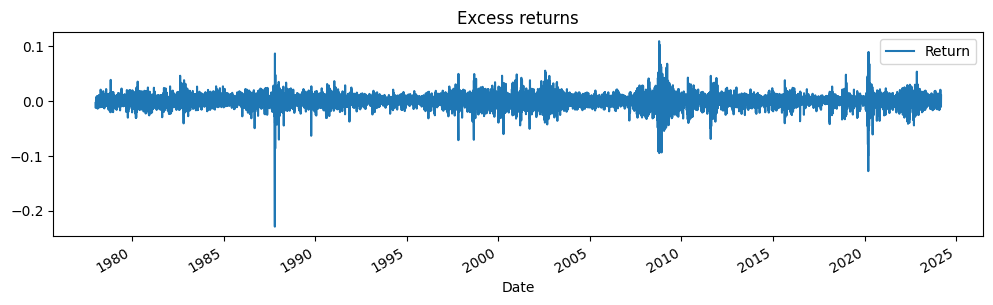

In [4]:
# Get the dataset



dta_kns = raw.loc[:'2024'] - raw.loc[:'2024'].mean()


# Plot the dataset
dta_kns.plot(title="Excess returns", figsize=(12, 3))

# Fit the model
mod_kns = sm.tsa.MarkovRegression(
    dta_kns, k_regimes=2, trend="n", switching_variance=True
)
res_kns = mod_kns.fit()


In [5]:
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 Return   No. Observations:                11642
Model:               MarkovRegression   Log Likelihood               37804.540
Date:                Sun, 10 Mar 2024   AIC                         -75601.080
Time:                        15:28:13   BIC                         -75571.631
Sample:                             0   HQIC                        -75591.186
                              - 11642                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.277e-05   1.17e-06     44.953      0.000    5.05e-05    5.51e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   1.48e-05     25.565      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9896      0.001    666.124      0.000       0.987       0.992
p[1->0]        0.0363      0.005      6.804      0.000       0.026       0.047
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

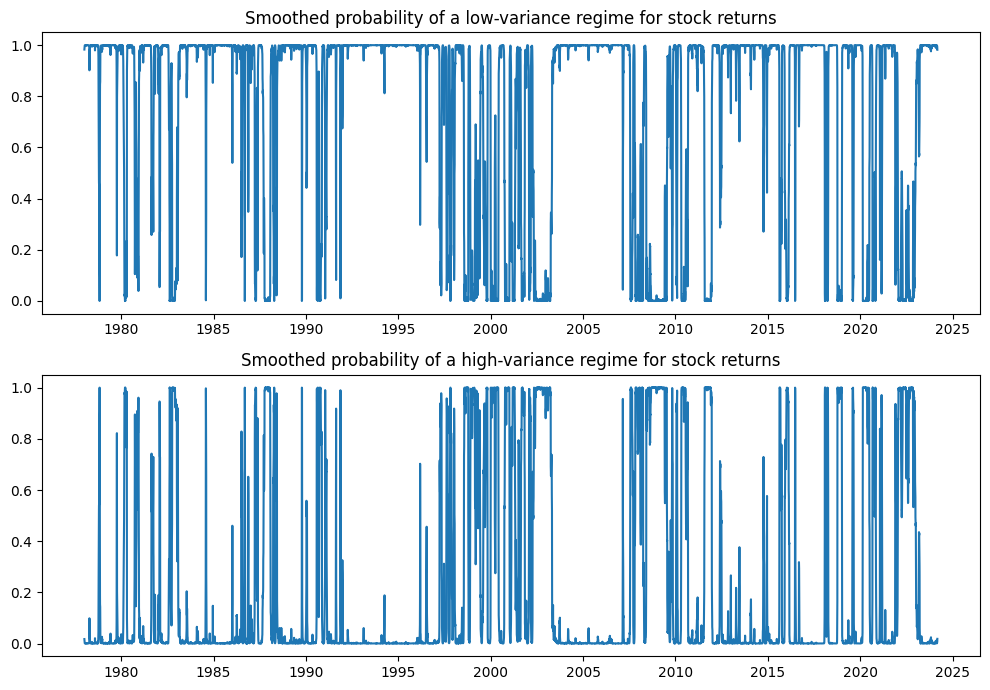

In [6]:
fig, axes = plt.subplots(2, figsize=(10, 7))

ax = axes[0]
ax.plot(res_kns.smoothed_marginal_probabilities[0])
ax.set(title="Smoothed probability of a low-variance regime for stock returns")

ax = axes[1]
ax.plot(res_kns.smoothed_marginal_probabilities[1])
ax.set(title="Smoothed probability of a high-variance regime for stock returns")

fig.tight_layout()


## On average, low variance lasts 96 days and high variance lasts 27 days

In [7]:
print(res_kns.expected_durations)

[96.043706   27.55894325]


## Get daily S&P data

In [8]:
sp = pd.read_csv('s&p1978_2024.csv', skipfooter=1,engine='python')
# sp.drop([' Open', ' High', ' Low', ' Close'],axis=1,inplace=True)
sp.rename(columns={' Return': 'Return', ' Date':'Date',' Open':'Open',' High':'High',' Low':'Low',' Close':'Close'},inplace=True)
sp=sp.iloc[::-1]
# Convert the 'date' column to datetime
sp['Date'] = pd.to_datetime(sp['Date'])

# Format the 'date' column in the desired format
sp['Date'] = sp['Date'].dt.strftime('%Y-%m-%d')
sp.set_index('Date',inplace=True)
sp1= sp.drop(columns=['Open','High','Low','LN_Return'])


C:\Users\alden\AppData\Local\Temp\ipykernel_25492\1019101397.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp['Date'] = pd.to_datetime(sp['Date'])


## Calculate Triangular Moving Average

In [9]:
def calculate_TMA(data, period):
    """Calculates a Triangular Moving Average (TMA).

    Args:
        data: A pandas Series of price data
        period: The period of the moving average.

    Returns:
        A pandas Series containing the TMA calculation
    """

    SMA = data.rolling(period).mean()  # Calculate a simple moving average first
    TMA = SMA.rolling(period).mean()   # Smooth the SMA to get the TMA
    return TMA

period = 250
TMA = calculate_TMA(sp1, period)
sp1['TMA']=TMA['Close']

In [10]:
sp1.tail()

,Close,TMA
Date,,
2024-03-01,5137.08,4121.941987
2024-03-04,5130.95,4123.629108
2024-03-05,5078.65,4125.336655
2024-03-06,5104.76,4127.066579
2024-03-07,5157.36,4128.821788


## Calculate ATR

In [11]:
from ta.volatility import AverageTrueRange

atr = AverageTrueRange(high=sp['High'], low=sp['Low'], close=sp['Close'], window=20)
sp1['ATR']=atr.average_true_range()

## Add state probabilities to the dataframe

In [12]:
# sp1[['low_var','high_var']]=res_kns.smoothed_marginal_probabilities

res_kns_smoothed_marginal_probabilities = pd.DataFrame(res_kns.smoothed_marginal_probabilities)
sp1.index = pd.to_datetime(sp1.index)

res_kns_smoothed_marginal_probabilities.index = pd.to_datetime(res_kns_smoothed_marginal_probabilities.index)
# Resample the monthly data to daily data
marginal_probs_daily = res_kns_smoothed_marginal_probabilities.resample('D').ffill()

# Combine the two dataframes
sp1 = pd.concat([sp1, marginal_probs_daily], axis=1)
sp1.tail()

,Close,TMA,ATR,0,1
Date,,,,,
2024-03-03,NaN,NaN,NaN,0.997789,0.002211
2024-03-04,5130.95,4123.629108,41.358269,0.996623,0.003377
2024-03-05,5078.65,4125.336655,42.996855,0.993002,0.006998
2024-03-06,5104.76,4127.066579,43.313013,0.989701,0.010299
2024-03-07,5157.36,4128.821788,44.190362,0.981558,0.018442


In [13]:
sp1.rename(columns={0:'low_var',1:'high_var'},inplace=True)
sp1.tail()

,Close,TMA,ATR,low_var,high_var
Date,,,,,
2024-03-03,NaN,NaN,NaN,0.997789,0.002211
2024-03-04,5130.95,4123.629108,41.358269,0.996623,0.003377
2024-03-05,5078.65,4125.336655,42.996855,0.993002,0.006998
2024-03-06,5104.76,4127.066579,43.313013,0.989701,0.010299
2024-03-07,5157.36,4128.821788,44.190362,0.981558,0.018442


## Plotting TMA with closing price

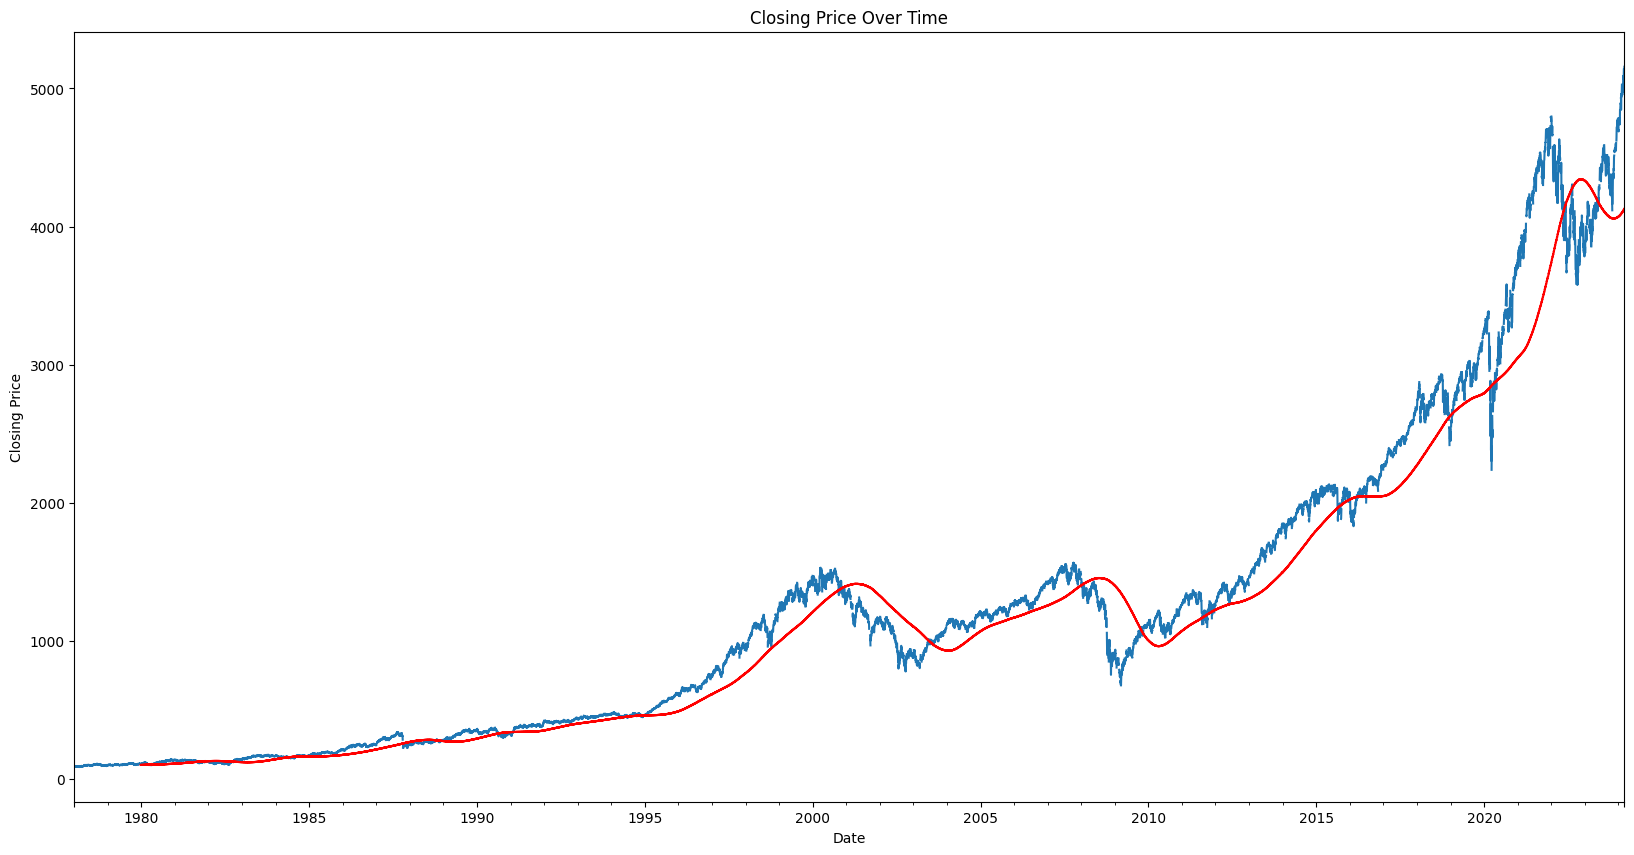

In [14]:
# Assuming 'sp' is your DataFrame and 'Close' is the column with closing prices
sp1['Close'].plot(figsize=(20,10))
sp1['TMA'].plot(color='red', label='TMA')

plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')

plt.show()

In [15]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming 'sp1' is your DataFrame, 'Close' is the column with closing prices,
# # and 'TMA' is the column with the moving average

# plt.figure(figsize=(50,25))

# # Plot the closing price and moving average
# plt.plot(sp1.index, sp1['Close'], label='Close', color='black')
# plt.plot(sp1.index, sp1['TMA'], label='Moving Average', color='blue')

# # Color the background green where the closing price is above the moving average
# plt.fill_between(sp1.index, sp1['Close'].min(), sp1['Close'].max(), where=(sp1['Close'] > sp1['TMA']), color='green', alpha=0.5, interpolate=True)

# # Color the background red where the closing price is below the moving average
# plt.fill_between(sp1.index, sp1['Close'].min(), sp1['Close'].max(), where=(sp1['Close'] <= sp1['TMA']), color='red', alpha=0.5, interpolate=True)

# plt.title('Closing Price and Moving Average Over Time')
# plt.xlabel('Date')
# plt.ylabel('Price')

# # Add a legend
# plt.legend()

# plt.show()

## Categorise

In [16]:
def categorize(row, prev_row):
    if abs(row['Close'] - row['TMA']) < row['ATR']:
        return prev_row['color']
    elif row['Close'] > row['TMA']:
        return 'blue' if row['low_var'] > row['high_var'] else 'green'
    else:
        return 'pink' if row['low_var'] > row['high_var'] else 'red'

sp1['color'] = None
prev_row = {'color': 'green'}  # Initialize with the color of the first row
colors = []
for i, row in sp1.iterrows():
    colors.append(categorize(row, prev_row))
    prev_row = row
sp1['color'] = colors

In [17]:
sp1.dropna(inplace=True)

In [18]:
sp1.tail()

,Close,TMA,ATR,low_var,high_var,color
Date,,,,,,
2024-03-01,5137.08,4121.941987,42.351336,0.997789,0.002211,blue
2024-03-04,5130.95,4123.629108,41.358269,0.996623,0.003377,blue
2024-03-05,5078.65,4125.336655,42.996855,0.993002,0.006998,blue
2024-03-06,5104.76,4127.066579,43.313013,0.989701,0.010299,blue
2024-03-07,5157.36,4128.821788,44.190362,0.981558,0.018442,blue


c:\Users\alden\OneDrive\Documents\GitHub\Regime-Shift-Algorithmic-Trading-Bot\quantfin\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


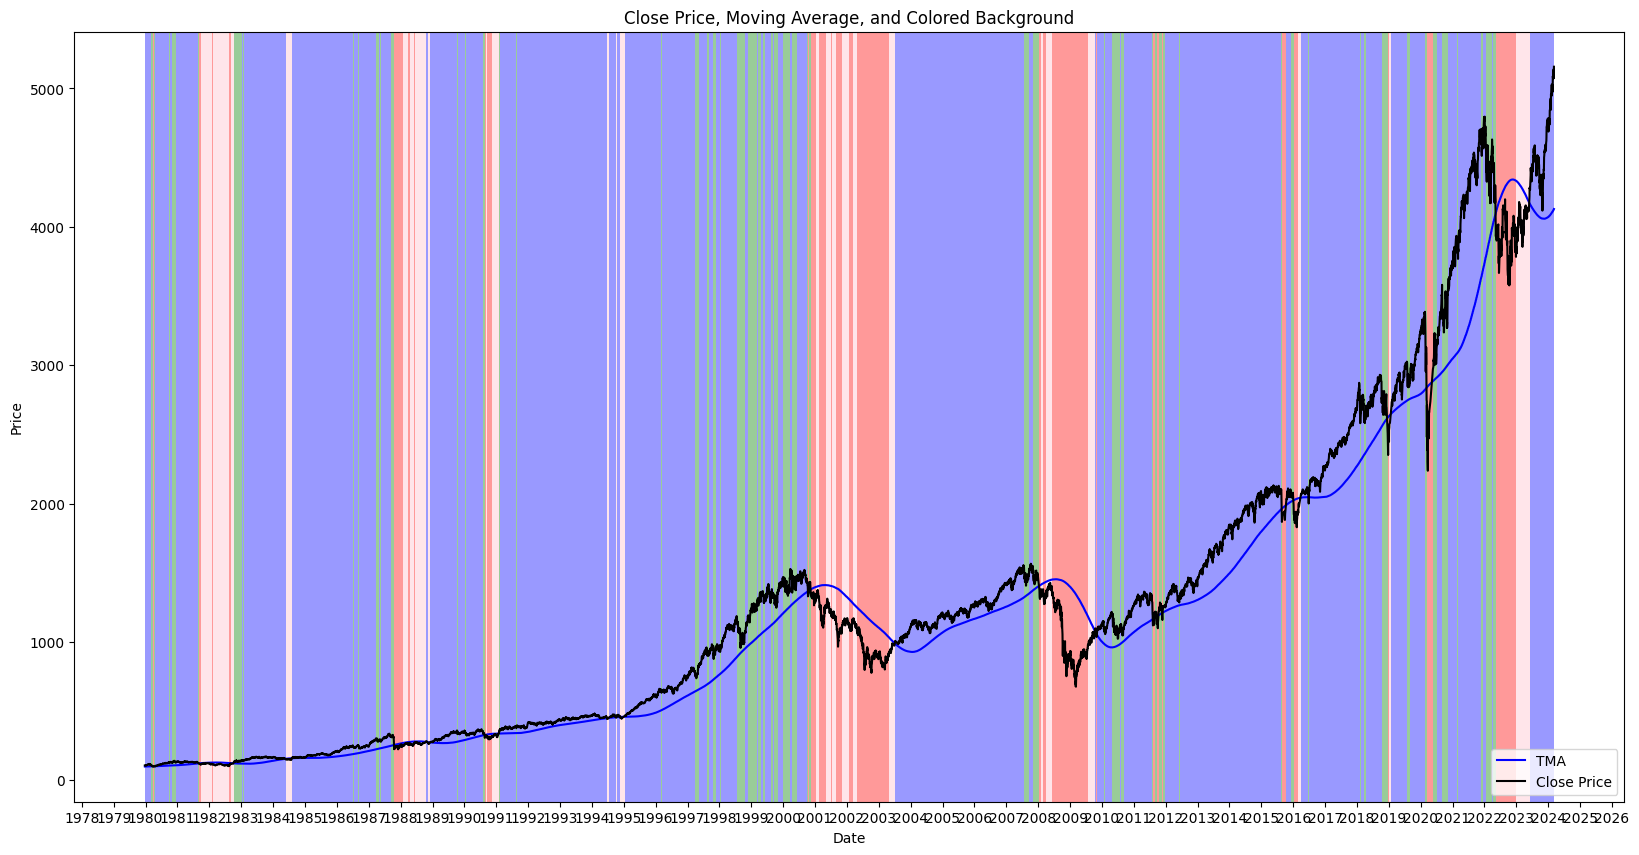

In [19]:
#green = bullish + high variance
#blue = bullish + low variance
#purple = bearish + low variance
#red = bearish + high variance
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd 
from matplotlib.patches import Patch


plt.figure(figsize=(20, 10))
plt.plot(sp1.index, sp1['TMA'], label='TMA', color='blue') 
plt.plot(sp1.index, sp1['Close'], label='Close Price', color='black') 

for i, row in sp1.iterrows():
    start_date = i
    end_date = sp1.index[sp1.index.get_loc(i) + 1] if i != sp1.index[-1] else i
    bg_color = row['color']

    plt.axvspan(start_date, end_date, facecolor=bg_color, alpha=0.4)

plt.title('Close Price, Moving Average, and Colored Background')
plt.xlabel('Date')
plt.ylabel('Price')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.show()

In [184]:
sp2 = sp1[8000:]
sp1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10654 entries, 1979-12-24 to 2024-03-01
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     10654 non-null  float64
 1   TMA       10654 non-null  float64
 2   ATR       10654 non-null  float64
 3   low_var   10654 non-null  float64
 4   high_var  10654 non-null  float64
 5   color     10654 non-null  object 
dtypes: float64(5), object(1)
memory usage: 840.7+ KB


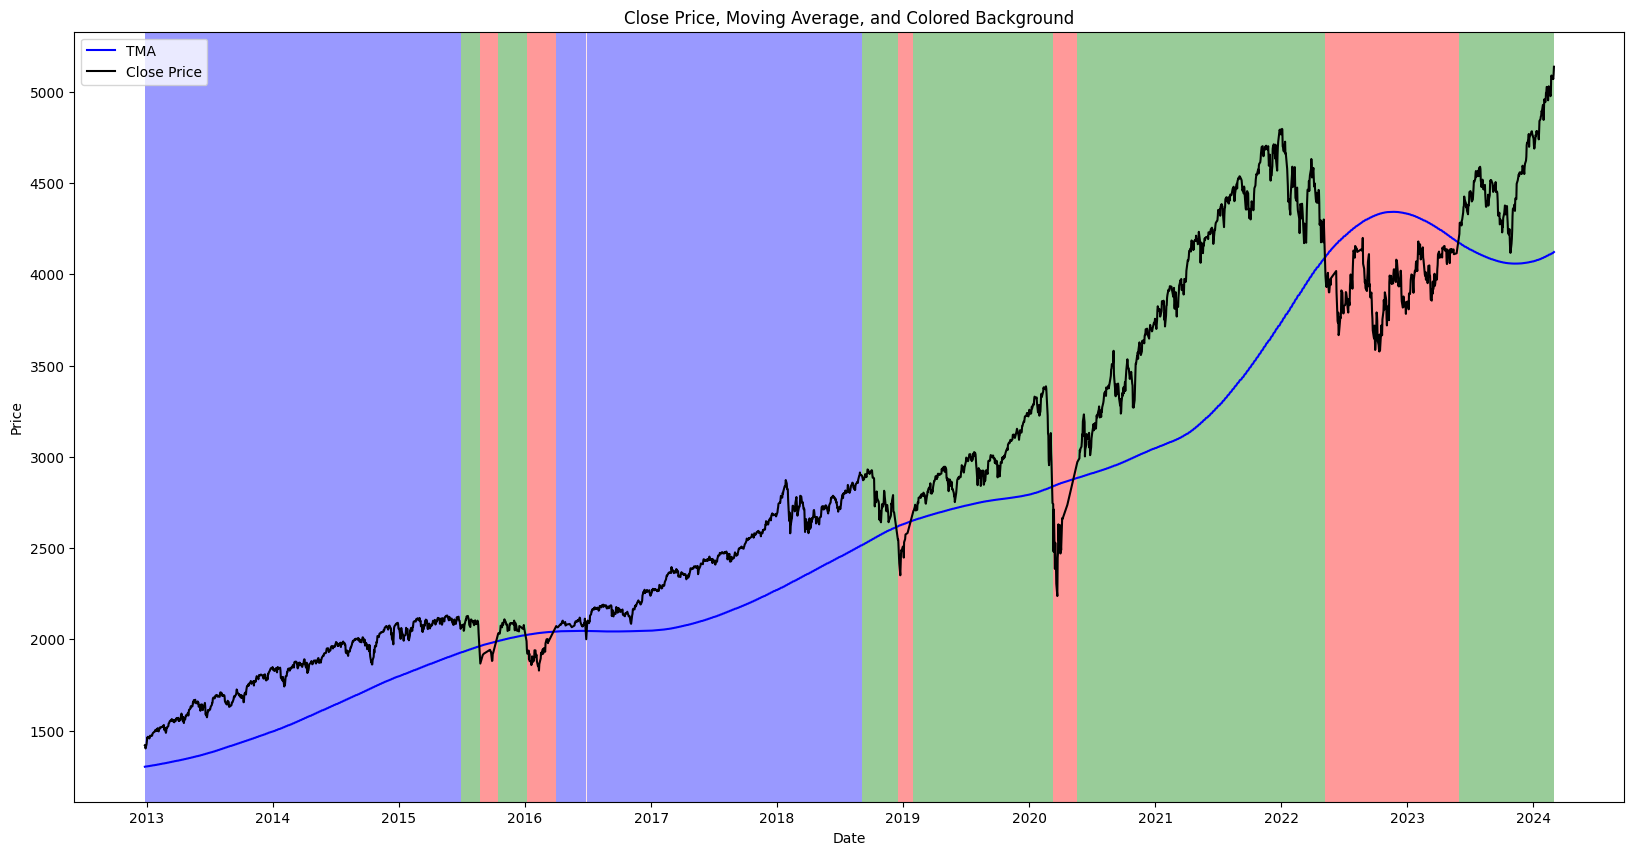

In [185]:
sp2.index = pd.to_datetime(sp2.index)
plt.figure(figsize=(20, 10))

plt.plot(sp2.index, sp2['TMA'], label='TMA', color='blue') 
plt.plot(sp2.index, sp2['Close'], label='Close Price', color='black') 

for i, row in sp2.iterrows():
    start_date2 = i
    end_date2 = sp2.index[sp2.index.get_loc(i) + 1] if i != sp2.index[-1] else i
    bg_color = row['color']

    plt.axvspan(start_date2, end_date2, facecolor=bg_color, alpha=0.4)

plt.title('Close Price, Moving Average, and Colored Background')
plt.xlabel('Date')
plt.ylabel('Price')


# Set the date format
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.show()